**Business Undertanding**

**Data Understanding**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# import warnings
# warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv('data/kc_house_data.csv')

**Data Preparation**: Data Cleaning

Previewing the data I can see there are some null values I'll have to deal with. These are coming from year renovated, view, and waterfront. It also looks like sqft_basement is an object not at integer. On a closer look, many of the rows contain a '?'. I'm going to fill nulls and examine the data more closely. 

For Waterfront and View: 
 - There are only 146 houses that are coded as waterfront. I am going to fill the null values to 0 since it won't affect the distribution much 
 - The view column has 63 null values. This column describes how many times a house has been viewed (not the views from the house), which I don't see as being really important as a feature because there are a lot of reasons it could/could not have been viewed a given number of times. I am going to fill these nulls with a 0 assuming they were not available to view.

In [5]:
data['waterfront'].fillna(0.0, inplace=True)
data['view'].fillna(0.0, inplace=True)

For year renovated, I am going to assume the nulls represent houses that were not renovated. I'm going to fill the nulls with 0, but also make a binary indicator column that just tells me whether the house was or was not renovated instead of what year. I'll keep both columns for now.

In [6]:
data['yr_renovated'].fillna(0.0, inplace=True)

#new column  
data['is_renovated'] = 0

# loop through the data and input a 1 where the house was renovated
for row in data.index:
    if data['yr_renovated'][row] != 0.0:
        data['is_renovated'][row] = 1

Lastly for squarefoot basement, I am going to replace all the '?' symbols with 0 to make this column readable, assuming these houses do not have basements.

In [7]:
data['sqft_basement'] = data['sqft_basement'].map(lambda x: x.replace("?", "0"))
data['sqft_basement'] = pd.to_numeric(data['sqft_basement'], downcast='integer')

In [8]:
# data.info()

After running a .describe and examining some columns, I see one outlier I want to remove because it looks incorrect - a house that has 33 bedrooms and 1.75 bath that cost only $640k.

In [9]:
data.drop(data.index[15856], inplace=True)

***Data Preparation***: Checking for multicollinearity, normalizing, scaling, encoding categorical data

First I'm going to separate my continuous from categorical columns. I am excluding ID, date and the sqft 15 columns for now. The dates are all from the same 2 years so there isn't a diverse amount of data and the neighboring house info is not relevant now but I could bring it in later.

In [74]:
cat_cols= ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'condition', 'grade', 'yr_built', 'view', 'is_renovated', 'zipcode']
con_cols = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']
geo_cols= ['lat', 'long']
y = data['price']
X_cols = data[cat_cols + con_cols + geo_cols]

Then I'm going to run a few visual techniques to take a look at my data and decide where I can clean it up for modeling. 

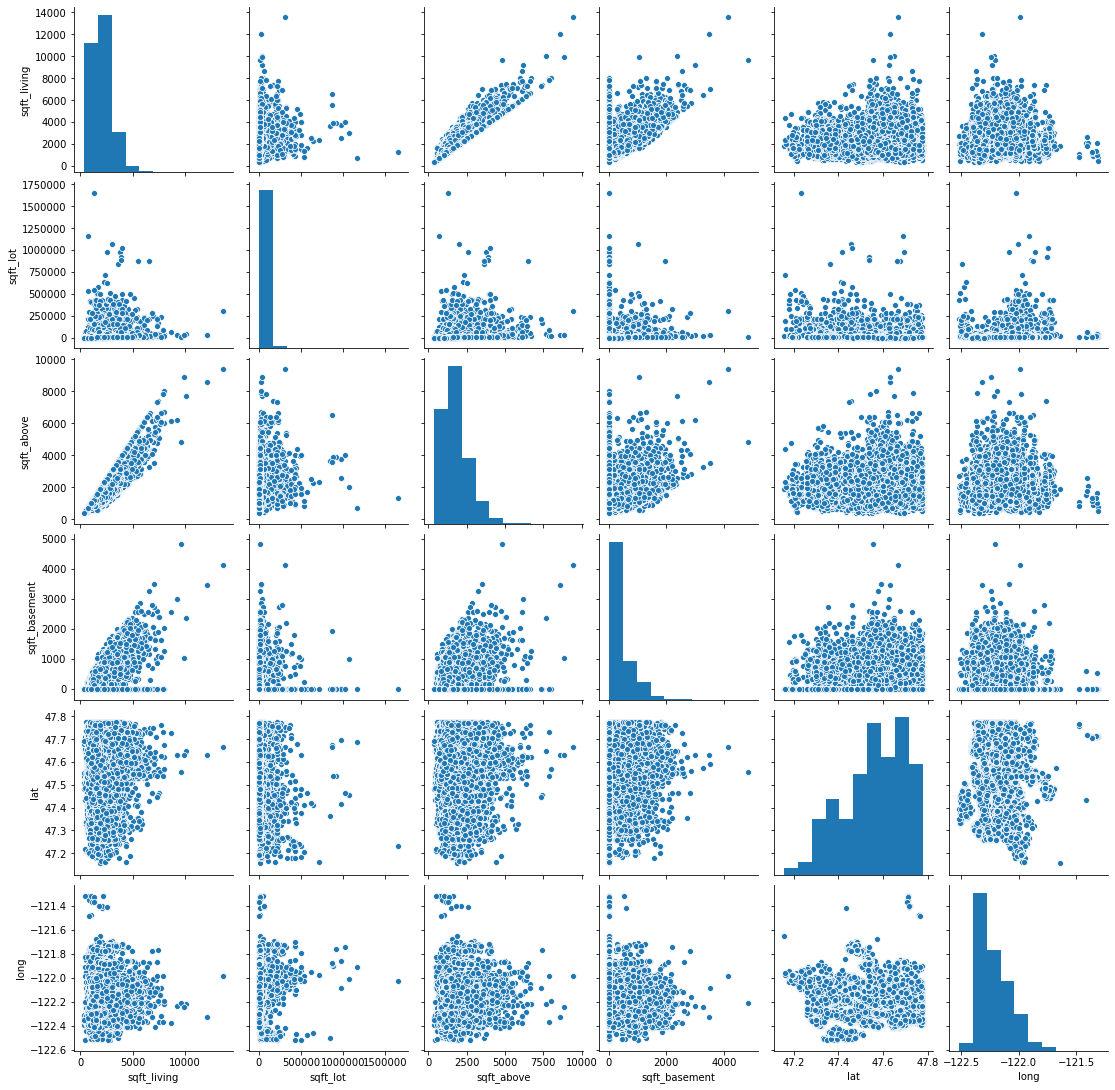

In [11]:
sns.pairplot(data[con_cols])

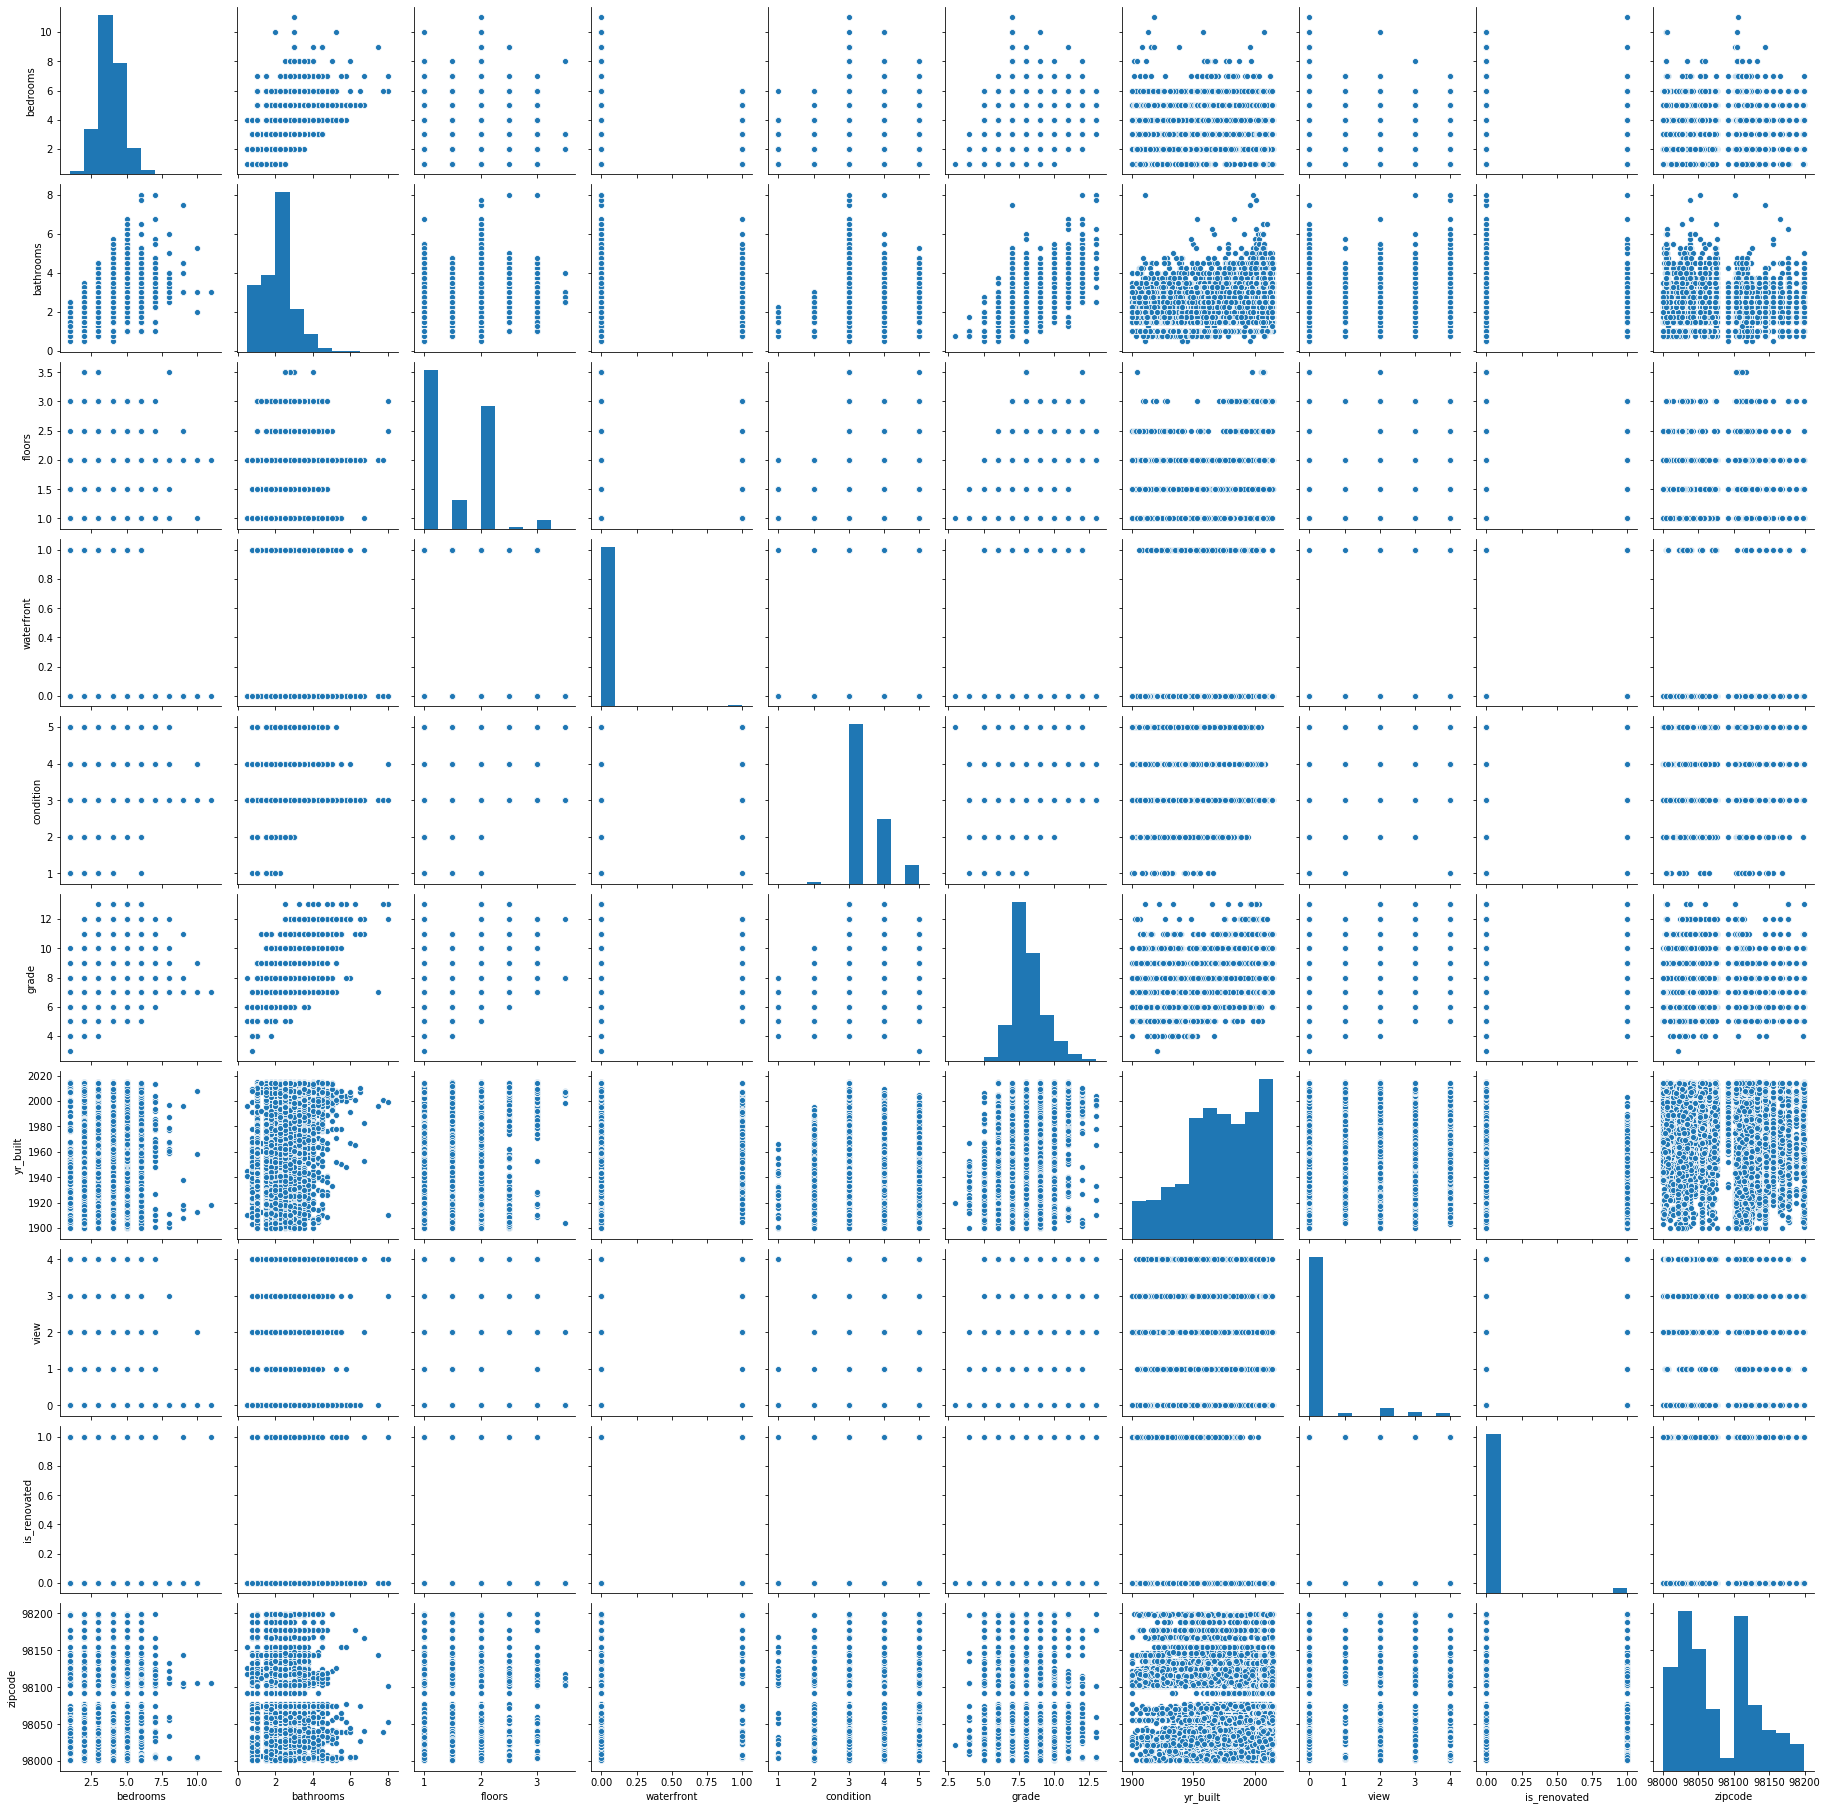

In [12]:
sns.pairplot(data[cat_cols])

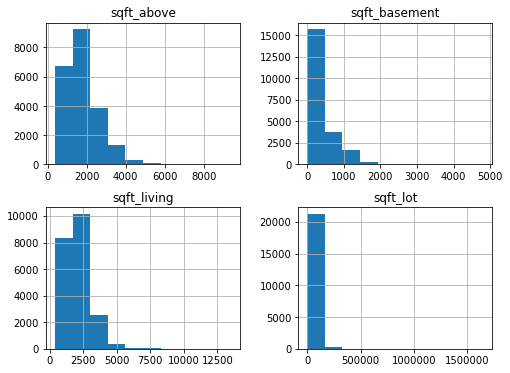

In [80]:
# use a GCA plot to look at histograms of the continuous variables
fig = plt.figure(figsize = (8,6))
ax = fig.gca()
data[con_cols].hist(ax = ax);


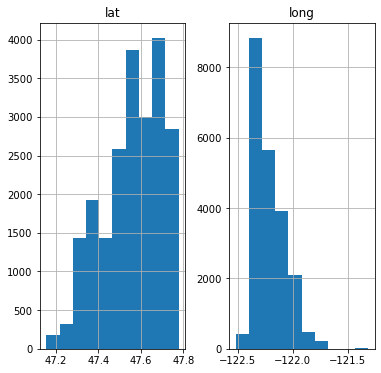

In [88]:
fig = plt.figure(figsize = (6,6))
ax = fig.gca()
data[geo_cols].hist(ax = ax);

In [91]:
# log transformations don't really su
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

geo_cols_norm = data[geo_cols].apply(normalize)

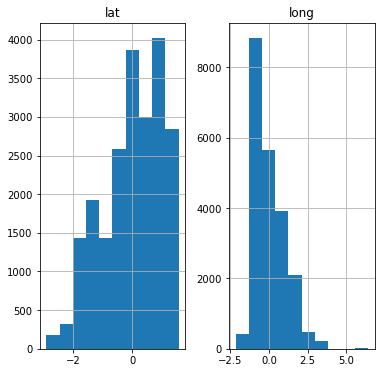

In [93]:
fig = plt.figure(figsize = (6,6))
ax = fig.gca()
geo_cols_norm.hist(ax = ax);

None of my continuous variables look normally distributed so I'm going to note that I'll probably need to go back and normalize them. 

(18, 0)

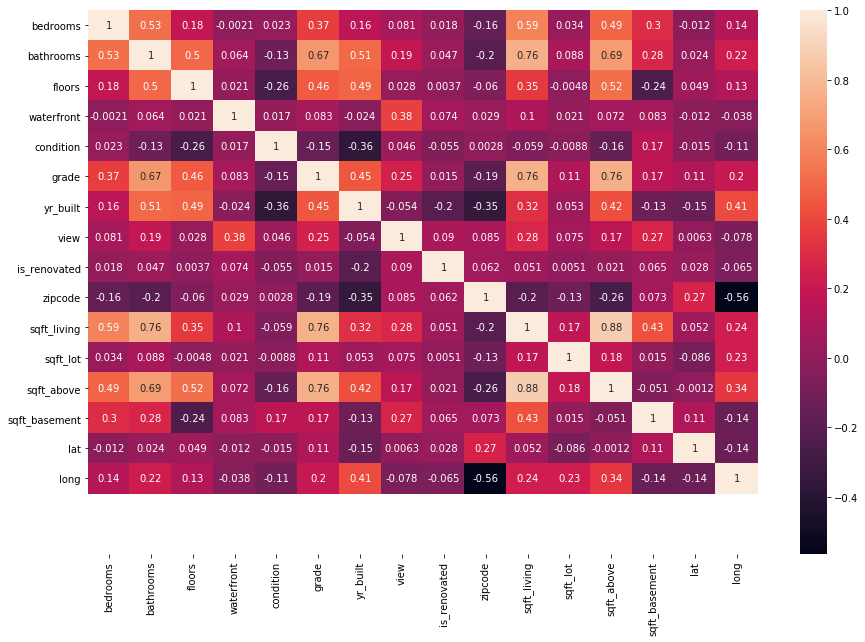

In [14]:
plt.figure(figsize = (15,10))
ax = sns.heatmap(data[cat_cols + con_cols].corr(), annot=True)
ax.set_ylim(18,0)

I can see that some features have high correlations: Bathrooms + sqft, grade & sqft, sqft above and sqft living

I'm going to go ahead and model my data to see what happens. I'll use the scikitlern method, create a train trest split, scale the data, and fit it to a model.

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_cols, y, test_size=0.3, random_state=20)

In [17]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
linreg = LinearRegression()
model = linreg.fit(X_train_scaled, y_train)

In [19]:
y_hat_train = linreg.predict(X_train_scaled)
y_hat_test = linreg.predict(X_test_scaled)

In [52]:
coefficients = linreg.coef_
coefficients = abs(coefficients)

In [68]:
coef_dict = dict(list(zip(X_cols.columns, coefficients)))
coef_df = pd.DataFrame.from_dict(coef_dict, orient='index')
coef_df.sort_values(by=[0], ascending=False)

,0
grade,115779.362608
sqft_above,92686.064244
lat,84841.898012
yr_built,79095.917116
sqft_living,76405.581568
waterfront,49244.418763
view,46018.210825
bedrooms,35740.034473
bathrooms,34873.638155
sqft_basement,33281.244021


In [22]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [23]:
from sklearn.metrics import mean_squared_error, r2_score

In [55]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)
train_rmse = np.sqrt(mean_squared_error(y_train, y_hat_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_hat_test))
print('Train Root Mean Squarred Error:', train_rmse)
print('Test Root Mean Squarred Error:', test_rmse)

Train Mean Squarred Error: 41399564395.11086
Test Mean Squarred Error: 38634665984.12906
Train Root Mean Squarred Error: 203468.8290503262
Test Root Mean Squarred Error: 196557.02985171773


the test error is not worse than the train error, but they're both huge.

In [56]:
print(f'train r2: {r2_score(y_train, y_hat_train)}')
print(f'test r2: {r2_score(y_test, y_hat_test)}')

train r2: 0.7005339627471194
test r2: 0.6964788014790179


The R2 score is not terrible but there is a LOT of error. Circling back to the Data Preparation stage, I want to make some transformations on columns that do not fit the assumptions for linear regression. I'll start with log transforming the continuous variables, since all look non-normal
and then address the multicollinearity.

In [58]:
# log features
log_names = [f'{column}_log' for column in data[con_cols].columns]

X_cols_log = np.log1p(data[con_cols])
X_cols_log.columns = log_names

# data_log = pd.DataFrame([])
# data_log['loglat'] = np.log1p(data['lat'])
# data_log['loglong'] = np.log1p(data['long'])
# data_log['logsqftabove'] = np.log1p(data['sqft_above'])
# data_log['logsqftbasement'] = np.log1p(data['sqft_basement'])
# data_log['logsqftliving'] = np.log1p(data['sqft_living'])
# data_log['logsqftlot'] = np.log1p(data['sqft_lot'])
X_cols_log

,sqft_living_log,sqft_lot_log,sqft_above_log,sqft_basement_log,lat_log,long_log
0,7.074117,8.639588,7.074117,0.000000,3.881795,NaN
1,7.852050,8.887791,7.682943,5.993961,3.886110,NaN
2,6.647688,9.210440,6.647688,0.000000,3.886457,NaN
3,7.581210,8.517393,6.957497,6.814543,3.881993,NaN
4,7.427144,8.997271,7.427144,0.000000,3.883969,NaN
...,...,...,...,...,...,...
21592,7.333676,7.031741,7.333676,0.000000,3.885665,NaN
21593,7.745436,8.668024,7.745436,0.000000,3.881784,NaN
21594,6.928538,7.208600,6.928538,0.000000,3.883508,NaN
21595,7.378384,7.778630,7.378384,0.000000,3.882275,NaN


In [64]:
long_log = np.log1p(data['long'])
long_log
data[con_cols]

,sqft_living,sqft_lot,sqft_above,sqft_basement,lat,long
0,1180,5650,1180,0,47.5112,-122.257
1,2570,7242,2170,400,47.7210,-122.319
2,770,10000,770,0,47.7379,-122.233
3,1960,5000,1050,910,47.5208,-122.393
4,1680,8080,1680,0,47.6168,-122.045
...,...,...,...,...,...,...
21592,1530,1131,1530,0,47.6993,-122.346
21593,2310,5813,2310,0,47.5107,-122.362
21594,1020,1350,1020,0,47.5944,-122.299
21595,1600,2388,1600,0,47.5345,-122.069


In [67]:
loglong = np.log1p(data['long']+1)
loglong

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
21592   NaN
21593   NaN
21594   NaN
21595   NaN
21596   NaN
Name: long, Length: 21596, dtype: float64

In [28]:
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

X_con_cols_norm = data[con_cols].apply(normalize)

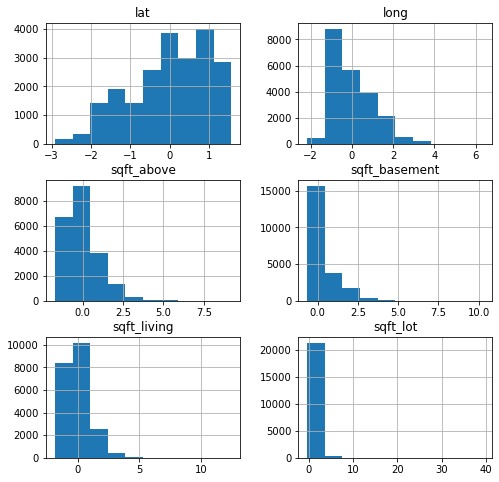

In [29]:
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
X_con_cols_norm.hist(ax = ax);

In [73]:
# import plotly.express as px
# px.scatter_geo(data_frame=data, lat='lat', lon='long')

TypeError: scatter_geo() got an unexpected keyword argument 'projection_scale'

ValueError: supplied range of [-inf, 8.480529207044645] is not finite

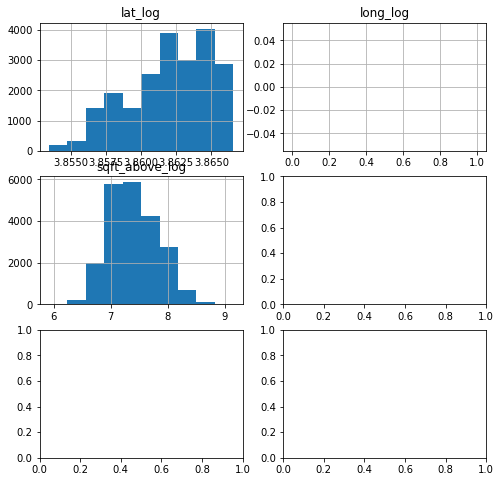

In [60]:
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
X_cols_log.hist(ax = ax);